In [13]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor


In [129]:
def compute_features(df):
    df['return'] = df['Close'].pct_change()
    
    # Moving Averages
    df['SMA_10'] = df['Close'].rolling(window=10, min_periods=1).mean()
    df['SMA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['SMA_50'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    
    # Volatility
    df['volatility_10'] = df['return'].rolling(window=10, min_periods=1).std()
    df['volatility_50'] = df['return'].rolling(window=50, min_periods=1).std()
    
    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / (loss + 1e-9)  # Prevent division by zero
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence Divergence)
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['BB_upper'] = df['SMA_20'] + (df['Close'].rolling(window=20, min_periods=1).std() * 2)
    df['BB_lower'] = df['SMA_20'] - (df['Close'].rolling(window=20, min_periods=1).std() * 2)
    
    return df.dropna()

def load_data(file_path, train_size=0.7, val_size=0.15, test_size=0.15):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Symbol', 'Date'])
    
    symbol_dfs = []
    for symbol, symbol_df in df.groupby('Symbol'):
        symbol_df = compute_features(symbol_df)
        
        num_rows = len(symbol_df)
        train_end = int(train_size * num_rows)
        val_end = int((train_size + val_size) * num_rows)
        
        train_data = symbol_df[:train_end]
        val_data = symbol_df[train_end:val_end]
        test_data = symbol_df[val_end:]
        
        symbol_dfs.append((train_data, val_data, test_data))
    
    train_df = pd.concat([t[0] for t in symbol_dfs])
    val_df = pd.concat([t[1] for t in symbol_dfs])
    test_df = pd.concat([t[2] for t in symbol_dfs])
    
    # Features
    features = ['Close', 'Volume', 'SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'volatility_10', 'volatility_50',
                'RSI_14', 'MACD', 'MACD_Signal', 'BB_upper', 'BB_lower']
    
    X_train, y_train = train_df[features].values, train_df['Close'].values
    X_val, y_val = val_df[features].values, val_df['Close'].values
    X_test, y_test = test_df[features].values, test_df['Close'].values
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, features

file_path = '../data/updated_data.csv'  
X_train, X_val, X_test, y_train, y_val, y_test, scaler, features = load_data(file_path)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(52400, 13) (11200, 13) (11300, 13)
(52400,) (11200,) (11300,)


In [130]:
# Train XGBoost model 
def train_xgb(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # 1. Check for and handle outliers in the target variable
    def handle_outliers(y):
        q1, q3 = np.percentile(y, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return np.clip(y, lower_bound, upper_bound)
    
    y_train_cleaned = handle_outliers(y_train)
    
    # 2. Feature preprocessing pipeline
    preprocessor = StandardScaler()
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_val_scaled = preprocessor.transform(X_val)
    X_test_scaled = preprocessor.transform(X_test)
    
    # 3. Create multiple XGBoost models with different configurations
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        n_jobs=-1
    )
    
    # 4. Hyperparameter tuning with RandomizedSearchCV
    param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Increase number of estimators
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Include a higher learning rate
    'max_depth': [3, 5, 7, 10],  # Increase depth of trees to allow learning deeper patterns
    'min_child_weight': [1, 2, 3, 5],  # More granular values to find optimal regularization
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Use lower values to prevent overfitting (subsample the data)
    'colsample_bytree': [0.6, 0.7, 0.8],  # Reduce this to limit feature overfitting
    'gamma': [0, 0.1, 0.2, 0.3],  # Introduce stronger regularization to reduce overfitting
    'reg_alpha': [0, 0.05, 0.1, 0.2],  # Add small values for L1 regularization to help generalization
    'reg_lambda': [0, 0.5, 1, 5],  # Regularization term, try mild values to control overfitting
    'scale_pos_weight': [1, 2],  # If dealing with imbalanced data, you might want to experiment with this
    }

    
    # Randomized search for better hyperparameters
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,  # Adjust based on available computational resources
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        random_state=42
    )
    
    # Fit on the training data
    random_search.fit(X_train_scaled, y_train_cleaned, 
                     eval_set=[(X_val_scaled, y_val)],
                     verbose=False)
    
    # Get the best model from hyperparameter tuning
    model = random_search.best_estimator_
    
    # 6. Evaluate the model
    def evaluate_model(model, X, y, dataset_name):
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y, y_pred)
        print(f"{dataset_name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        return mse, rmse, mae
    
    print("Model Performance:")
    evaluate_model(model, X_train_scaled, y_train, "Training")
    evaluate_model(model, X_val_scaled, y_val, "Validation")
    evaluate_model(model, X_test_scaled, y_test, "Test")

    return model, preprocessor

model, preprocessor = train_xgb(X_train, y_train, X_val, y_val, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Model Performance:
Training - MSE: 44617.2439, RMSE: 211.2279, MAE: 25.1956
Validation - MSE: 108975.5707, RMSE: 330.1145, MAE: 50.9028
Test - MSE: 187901.7396, RMSE: 433.4763, MAE: 67.0626


In [8]:
import pickle

# Save the XGBoost model to a file.
with open('xgb_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the scaler to a file.
with open('xgb_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)


MSE: 35104.1585, RMSE: 187.3610, MAE: 37.9597


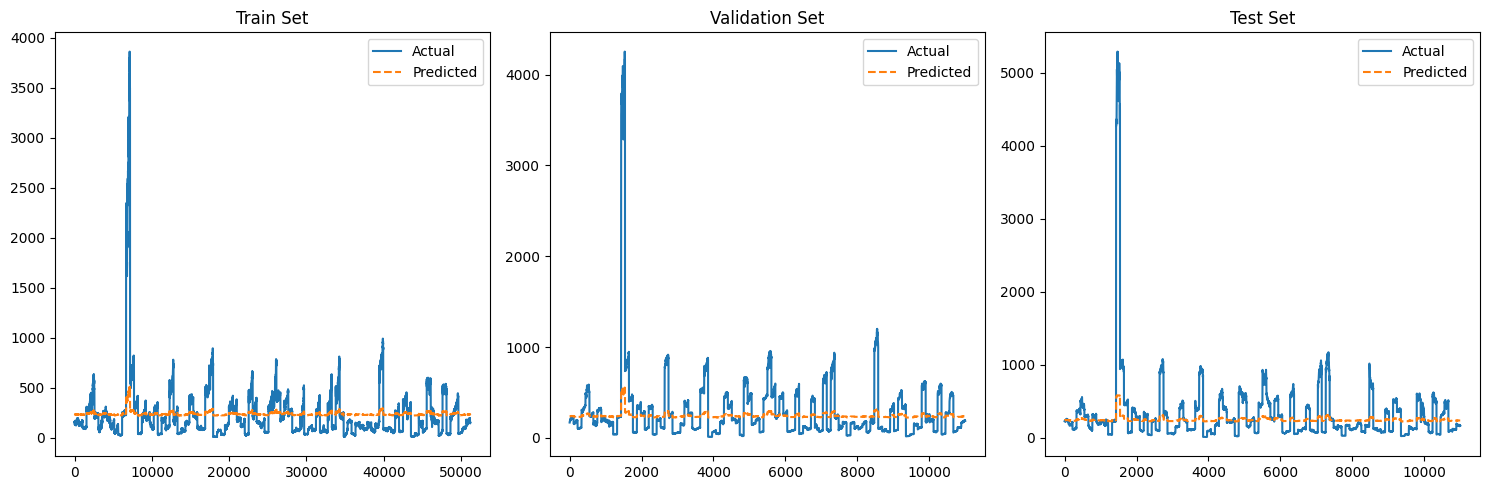

In [126]:
plt.figure(figsize=(15, 5))

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Plot Train
plt.subplot(1, 3, 1)
plt.plot(y_train, label="Actual")
plt.plot(y_train_pred, label="Predicted", linestyle="dashed")
plt.title("Train Set")
plt.legend()

# Plot Validation
plt.subplot(1, 3, 2)
plt.plot(y_val, label="Actual")
plt.plot(y_val_pred, label="Predicted", linestyle="dashed")
plt.title("Validation Set")
plt.legend()

# Plot Test
plt.subplot(1, 3, 3)
plt.plot(y_test, label="Actual")
plt.plot(y_test_pred, label="Predicted", linestyle="dashed")
plt.title("Test Set")
plt.legend()

plt.tight_layout()
plt.show()



In [48]:
# Calculate returns
def calculate_strategy_return(actual_prices, predicted_prices):
    returns = []
    for i in range(1, len(actual_prices)):
        if predicted_prices[i] > actual_prices[i - 1]:  # Buy signal
            returns.append(actual_prices[i] / actual_prices[i - 1] - 1)
        elif predicted_prices[i] < actual_prices[i - 1]:  # Sell signal
            returns.append(-1 * (actual_prices[i] / actual_prices[i - 1] - 1))
        else:
            returns.append(0)  

    strategy_return = sum(returns) * 100  
    return strategy_return

In [49]:
strategy_return = calculate_strategy_return(actual, predictions)
print(f"Strategy Return: {strategy_return:.2f}%")

Strategy Return: 2671637.93%
